In [1]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16582, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 16582 (delta 30), reused 39 (delta 18), pack-reused 16522
Receiving objects: 100% (16582/16582), 15.13 MiB | 18.48 MiB/s, done.
Resolving deltas: 100% (11387/11387), done.
/home/sochakraborty/uav_replenishment/venv/yolov5


/home/sochakraborty/uav_replenishment/venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
!pip install -qr requirements.txt  # install dependencies (ignore errors)
!pip install utils
import torch

from IPython.display import Image, clear_output  # to display images

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
     

You should consider upgrading via the '/home/sochakraborty/uav_replenishment/venv/bin/python3 -m pip install --upgrade pip' command.
  Using cached utils-1.0.2-py2.py3-none-any.whl
You should consider upgrading via the '/home/sochakraborty/uav_replenishment/venv/bin/python3 -m pip install --upgrade pip' command.
Setup complete. Using torch 2.3.0+cu121 _CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11011MB, multi_processor_count=68)


# Installing dataset from Roboflow

In [1]:
!pwd

/home/sochakraborty/uav_replenishment/venv


In [4]:
%cd /yolov5
!pip install -U roboflow

### Paste the link below

from roboflow import Roboflow
rf = Roboflow(api_key="6BSPzyvwTjTvvM4RkVxd")
project = rf.workspace("uav-replenishment").project("target-detection-ee3x5")
version = project.version(1)
dataset = version.download("yolov5")


  Using cached roboflow-1.1.28-py3-none-any.whl (74 kB)
  Using cached certifi-2023.7.22-py3-none-any.whl (158 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl (19 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl (54 kB)
  Using cached idna-2.10-py2.py3-none-any.whl (58 kB)
  Using cached opencv_python_headless-4.8.0.74-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.1 MB)
     |████████████████████████████████| 178 kB 9.9 MB/s eta 0:00:01
  Using cached python_magic-0.4.27-py2.py3-none-any.whl (13 kB)
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: certifi
    Found existing installation: certifi 2024.2.2
    Uninstalling certifi-2024.2.2:
      Successfully uninstalled certifi-2024.2.2
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12.1


Extracting Dataset Version Zip to Target-detection-1 in yolov5pytorch:: 100%|██████████| 876/876 [00:01<00:00, 875.85it/s] 


# Model configuration and architechture

In [5]:
!ls

benchmarks.py	 data	     LICENSE	     README.zh-CN.md	 train.py
CITATION.cff	 detect.py   models	     requirements.txt	 tutorial.ipynb
classify	 export.py   pyproject.toml  segment		 utils
CONTRIBUTING.md  hubconf.py  README.md	     Target-detection-1  val.py


In [6]:
# define number of classes based on YAML
# make sure that the file you imported from Roboflow is located in yolov5 folder
import yaml
with open("Target-detection-1/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

# experiments/venv/yolov5/Target-detection-1/data.yaml

In [7]:
%cat "Target-detection-1/data.yaml"

names:
- blue
- green
- red
nc: 3
roboflow:
  license: CC BY 4.0
  project: target-detection-ee3x5
  url: https://universe.roboflow.com/uav-replenishment/target-detection-ee3x5/dataset/1
  version: 1
  workspace: uav-replenishment
test: ../test/images
train: Target-detection-1/train/images
val: Target-detection-1/valid/images


In [8]:
#this is the model configuration we will use for our tutorial 
%cat "models/yolov5s.yaml"

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 

In [9]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [10]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector
Next, we'll fire off training!
Here, we are able to pass a number of arguments:

img: define input image size
batch: determine batch size
epochs: define the number of training epochs. (Note: often, 3000+ are common here!)
data: set the path to our yaml file
cfg: specify our model configuration
weights: specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive folder)
name: result names
nosave: only save the final checkpoint
cache: cache images for faster training

In [11]:
%pwd

'/home/sochakraborty/uav_replenishment/venv/yolov5'

In [23]:
# %cd ..

/Users/soumichakraborty/Documents/UCSD/SP24/CSE237D/UAVReplenishment/experiments/venv/yolov5


This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.


In [17]:
# train yolov5s on custom data for 100 epochs
# time its performance
%time
# %cd /content/yolov5
!python train.py --img 640 --batch 16 --epochs 150 --data 'Target-detection-1/data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache
     

CPU times: user 11 µs, sys: 3 µs, total: 14 µs
Wall time: 28.1 µs
train: weights=, cfg=./models/custom_yolov5s.yaml, data=Target-detection-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-307-g920c721e Python-3.9.5 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)

hyperparameters: lr0=0.01, lrf=0.01, mom

In [13]:
%pwd

'/home/sochakraborty/uav_replenishment/venv/yolov5'

In [ ]:
# # Start tensorboard
# # Launch after you have started training
# # logs save in the folder "runs"
# %load_ext tensorboard
# %tensorboard --logdir runs

In [38]:
current_directory = os.getcwd()
# Directory and file paths to join
directory = 'runs/train/yolov5s_results2'
file_name = 'results.png'

# Join the paths
results_path = os.path.join(current_directory, directory, file_name)

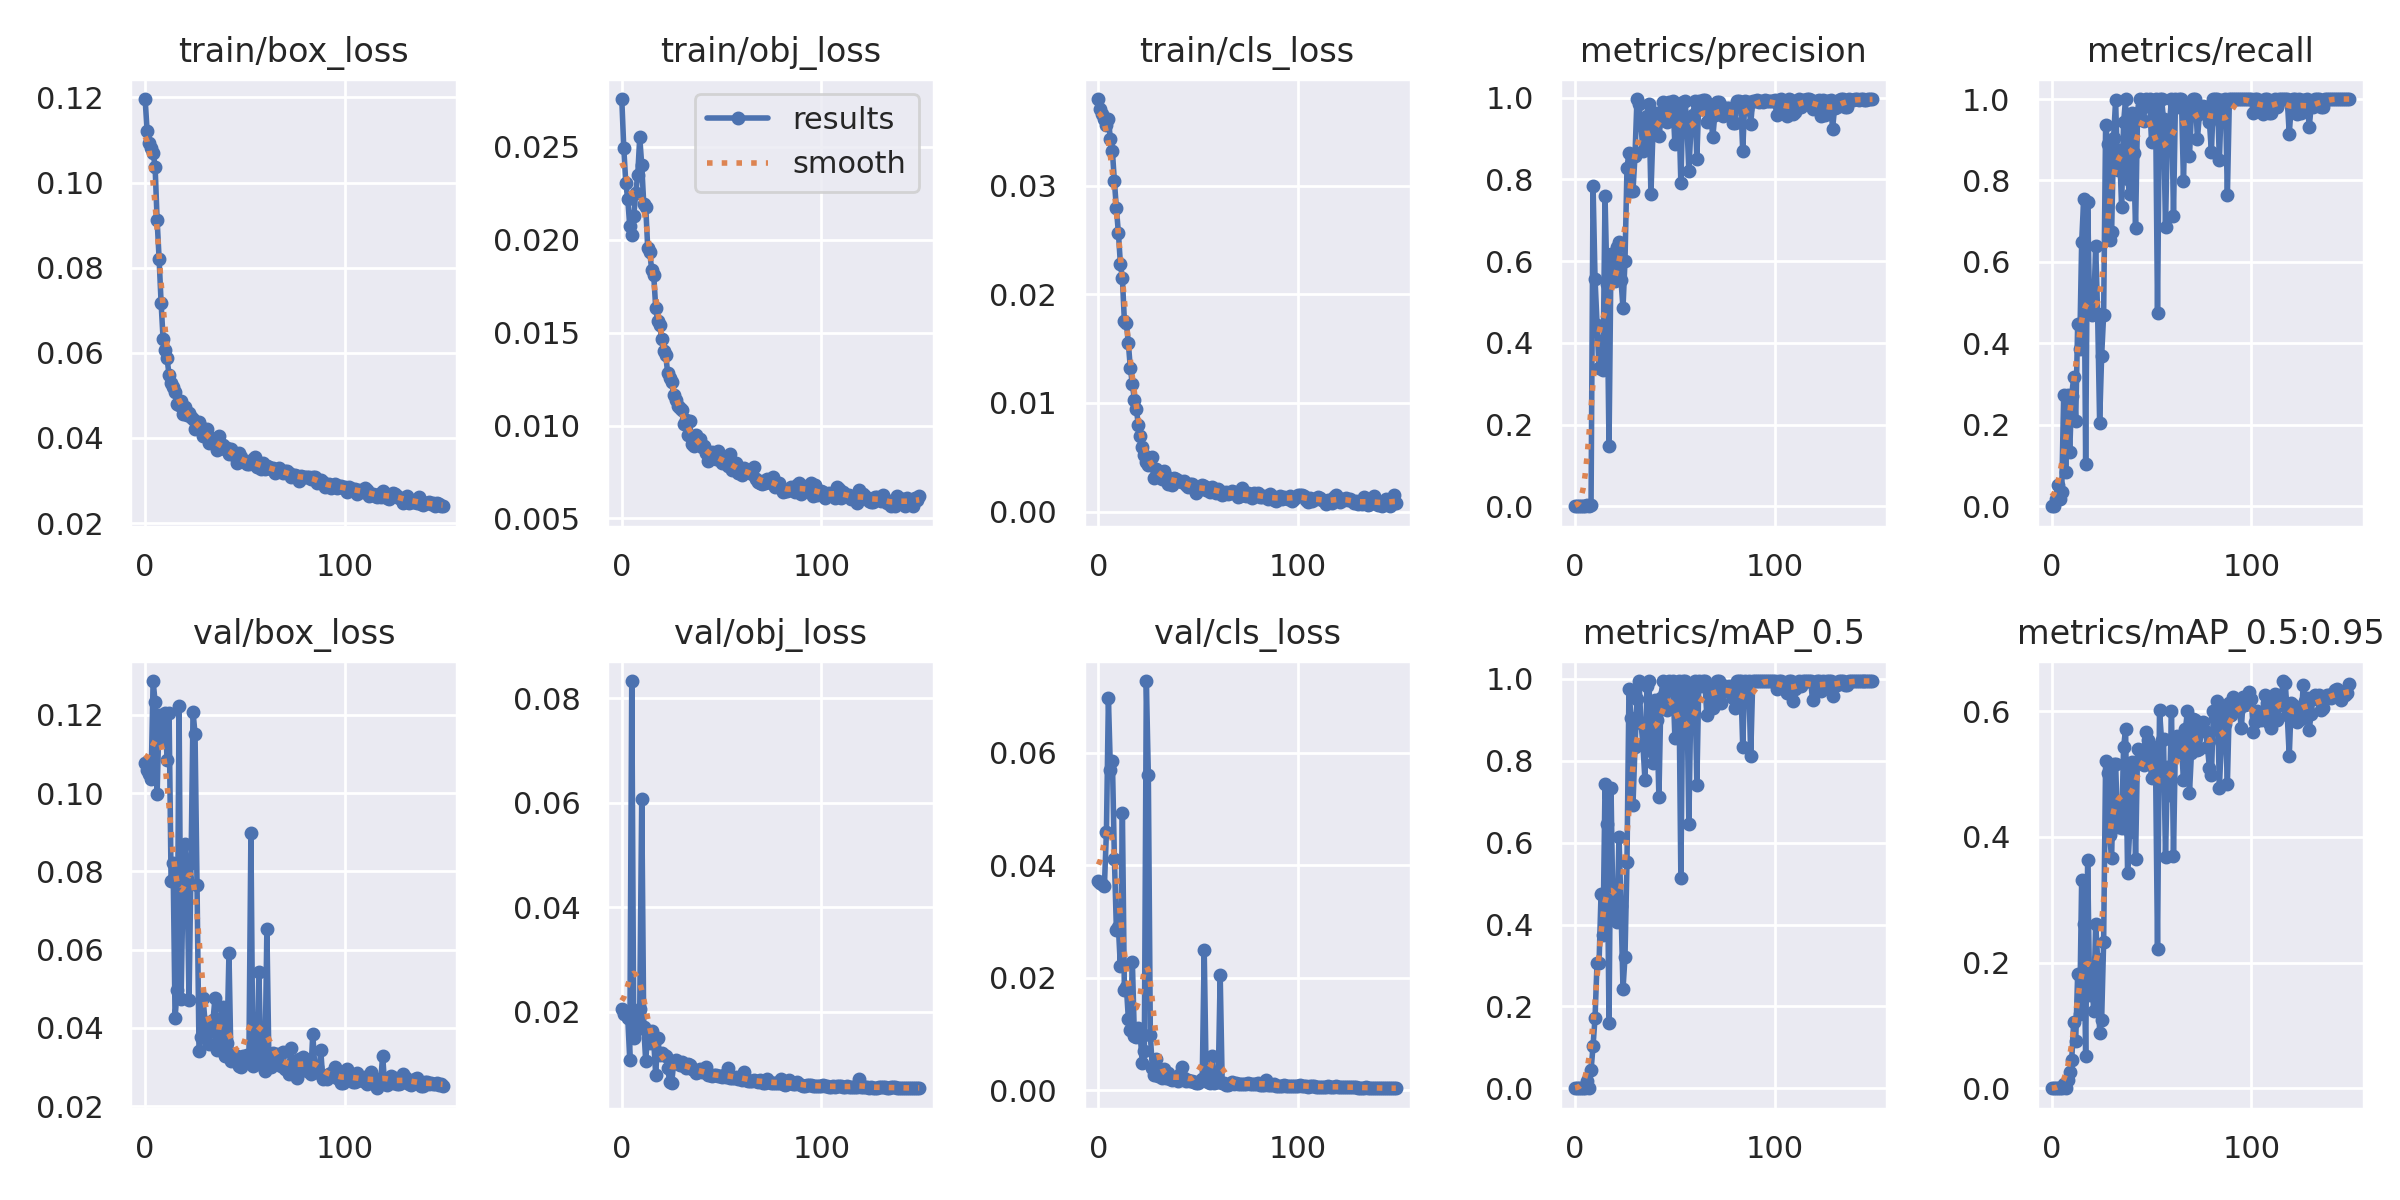

In [39]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename=results_path, width=1000)  # view results.png


GROUND TRUTH TRAINING DATA:


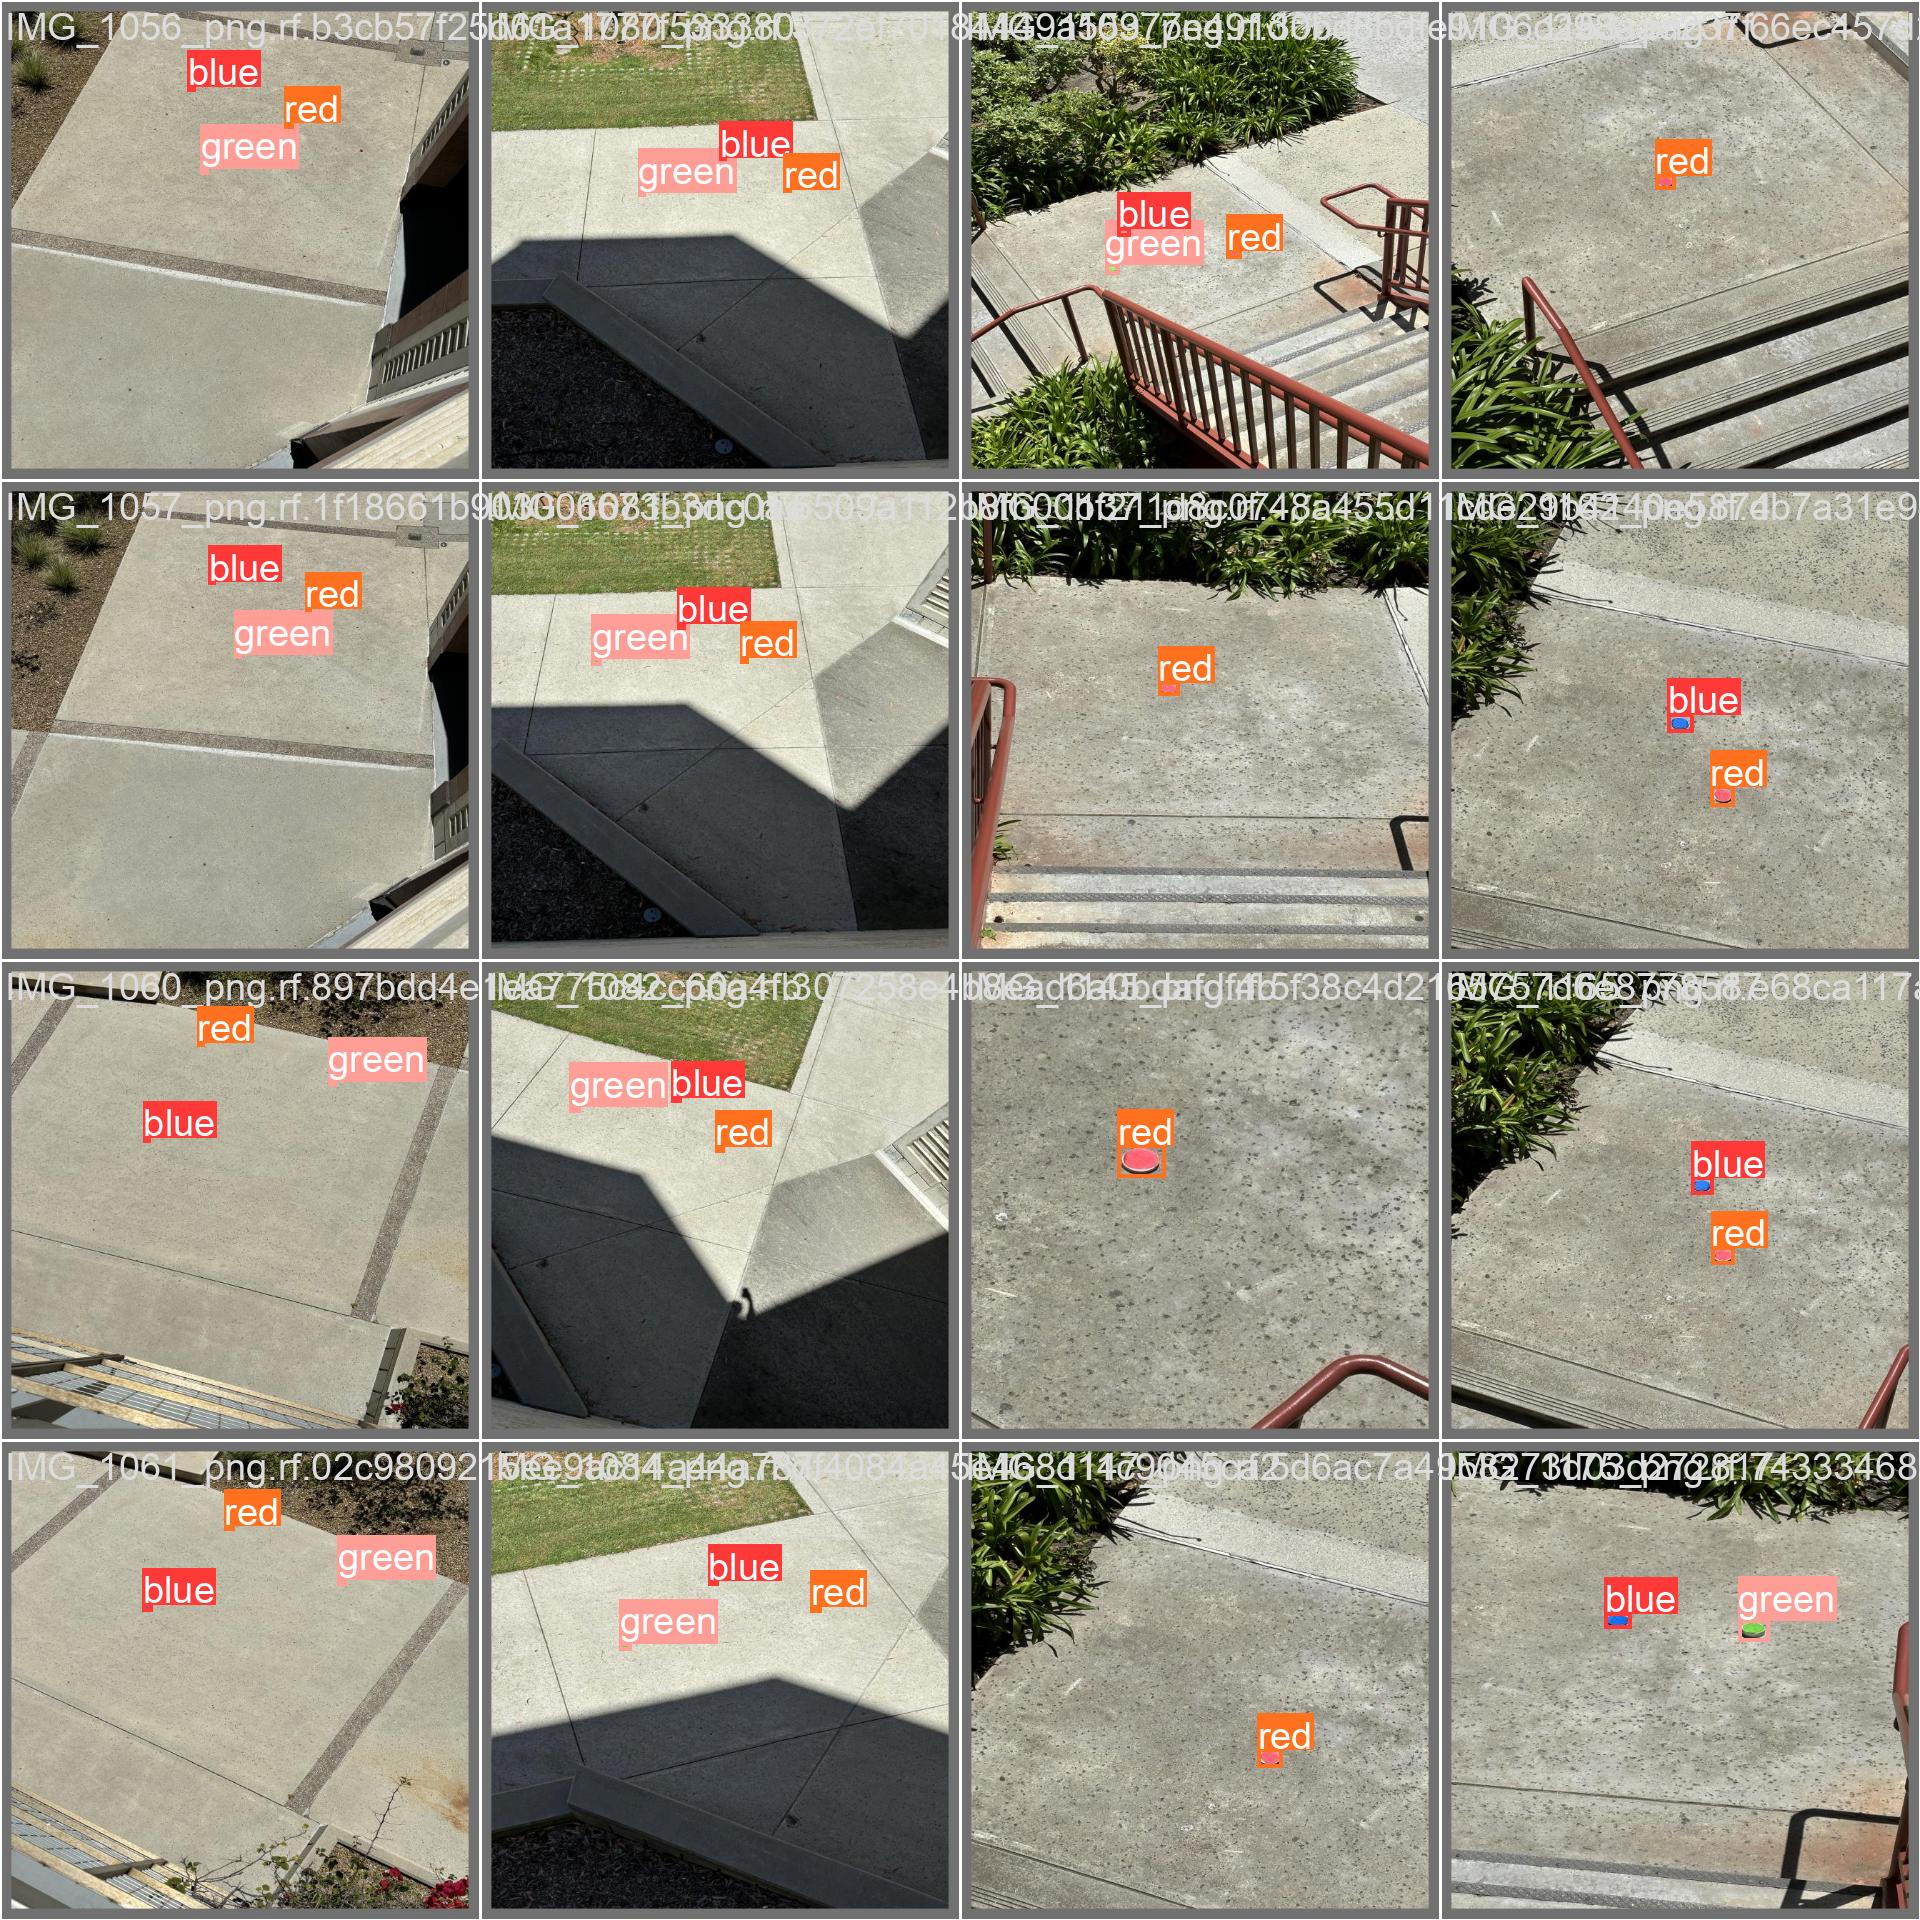

In [42]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/home/sochakraborty/uav_replenishment/venv/yolov5/runs/train/yolov5s_results2/val_batch0_labels.jpg', width=900)

In [46]:
%pwd

'/home/sochakraborty/uav_replenishment/venv/yolov5'

In [48]:
!python detect.py --weights "/home/sochakraborty/uav_replenishment/venv/yolov5/runs/train/yolov5s_results2/weights/best.pt" --img 640 --conf 0.4 --source "/home/sochakraborty/uav_replenishment/venv/yolov5/Target-detection-1/test/images"


detect: weights=['/home/sochakraborty/uav_replenishment/venv/yolov5/runs/train/yolov5s_results2/weights/best.pt'], source=/home/sochakraborty/uav_replenishment/venv/yolov5/Target-detection-1/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-307-g920c721e Python-3.9.5 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7251912 parameters, 0 gradients
image 1/14 /home/sochakraborty/uav_replenishment/venv/yolov5/Target-detection-1/test/images/IMG_1052_png.rf.cbbf6c25afe78803ad0a341b26f944b8.jpg: 640x640 1 blue, 1 green, 1 red, 10.3ms
image 2/1

# Export Saved YOLOv5 Weights for Future Inference
Now that our custom YOLOv5 object detector has been verified, we might want to take the weights out of Colab for use on a live computer vision task. 

In [49]:
%cp "/home/sochakraborty/uav_replenishment/venv/yolov5/runs/train/yolov5s_results/weights/best.pt" "/home/sochakraborty/uav_replenishment/venv"

In [6]:
%cd yolov5/

/home/sochakraborty/uav_replenishment/venv/yolov5


using dhist requires you to install the `pickleshare` library.


In [7]:
!pwd

/home/sochakraborty/uav_replenishment/venv/yolov5


In [8]:
# import roboflow

# roboflow.login()

# rf = roboflow.Roboflow()

# project = rf.workspace().project(PROJECT_ID)

# project.version(DATASET_VERSION).deploy(model_type=”yolov5”, model_path=f”{HOME}/runs/detect/train/”)
                                        
# %cd /yolov5
# !pip install -U roboflow
from roboflow import Roboflow


rf = Roboflow(api_key="6BSPzyvwTjTvvM4RkVxd")
project = rf.workspace("uav-replenishment").project("target-detection-ee3x5")
project.version(1).deploy(model_type="yolov5", model_path="/home/sochakraborty/uav_replenishment/venv/yolov5/runs/train/yolov5s_results/")
# dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...
View the status of your deployment at: https://app.roboflow.com/uav-replenishment/target-detection-ee3x5/1
Share your model with the world at: https://universe.roboflow.com/uav-replenishment/target-detection-ee3x5/model/1
